In [1]:
'''
very simple CNN for MNIST 
based on
https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py
'''

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

from keras.optimizers import SGD

from keras import backend as K


import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import numpy as np

Using TensorFlow backend.


In [2]:
# input image dimensions
img_rows, img_cols = 28, 28

# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 512
# this is fixed, we have 10 digits in our data set
num_classes = 10
# number of iterations over the complete training data
epochs = 20

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## X_train is of shape n_samples x 28 x 28
## for a CNN we want to keep the image shape
## need to explicitly tell keras that it is a gray value image
## so each image is 28x28x1 not 28x28x3
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# normalize image values to [0,1]
# interestingly the keras example code does not center the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
# convert class vectors to binary class matrices
# keras likes one hot encoding instead of class names
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [4]:
# create an empty network model
model = Sequential()

# --- input layer ---
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
# we could double the number of filters as max pool made the 
# feature maps much smaller 
# just not doing this to improve runtime
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten for fully connected classification layer
model.add(Flatten())
# note that the 10 is the number of classes we have
# the classes are mutually exclusive so softmax is a good choice
# --- fully connected layer ---
model.add(Dense(64, activation='relu'))
# --- classification ---
model.add(Dense(10, activation='softmax'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                51264     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total para

In [5]:
# this does all necessary compiling. In tensorflow this is much quicker than in theano
# the setup is our basic categorical crossentropy with stochastic gradient decent
# we also specify that we want to evaluate our model in terms of accuracy
sgd = SGD(lr=0.1, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [6]:
# this is now the actual training
# in addition to the training data we provide validation data
# this data is used to calculate the performance of the model over all the epochs
# this is useful to determine when training should stop
# in our case we just use it to monitor the evolution of the model over the training epochs
# if we use the validation data to determine when to stop the training or which model to save, we 
# should not use the test data, but a separate validation set. 
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

# once training is complete, let's see how well we have done
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 22s - loss: 0.7446 - acc: 0.7734 - val_loss: 0.1020 - val_acc: 0.9674
Epoch 2/20
60000/60000 [==============================] - 22s - loss: 0.0874 - acc: 0.9728 - val_loss: 0.0688 - val_acc: 0.9772
Epoch 3/20
60000/60000 [==============================] - 22s - loss: 0.0671 - acc: 0.9793 - val_loss: 0.0465 - val_acc: 0.9853
Epoch 4/20
60000/60000 [==============================] - 31s - loss: 0.0484 - acc: 0.9847 - val_loss: 0.0487 - val_acc: 0.9855
Epoch 5/20
60000/60000 [==============================] - 24s - loss: 0.0412 - acc: 0.9871 - val_loss: 0.0468 - val_acc: 0.9843
Epoch 6/20
60000/60000 [==============================] - 23s - loss: 0.0398 - acc: 0.9876 - val_loss: 0.0400 - val_acc: 0.9864
Epoch 7/20
60000/60000 [==============================] - 23s - loss: 0.0332 - acc: 0.9895 - val_loss: 0.0382 - val_acc: 0.9872
Epoch 8/20
60000/60000 [==============================

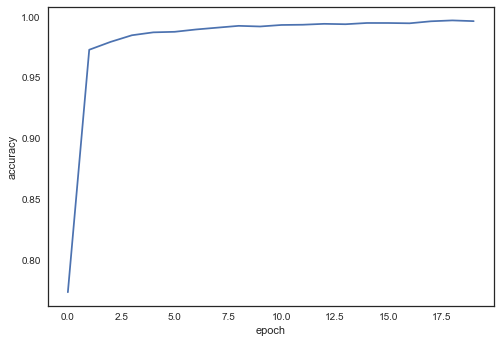

In [7]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")


In [8]:
# Look at the weights of the first layer
layer = model.layers[0]
# this actually returns a list 
# first element is W
# second element are all the biases b
weights = layer.get_weights()
# the weights are the number of pixels times the number of filters (hidden units)
print("Shape of W")
print(weights[0].shape)

Shape of W
(5, 5, 1, 16)


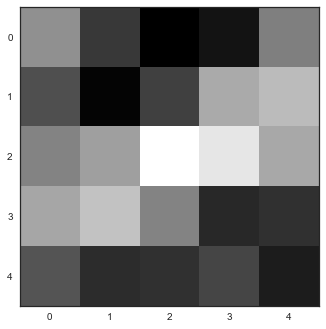

In [9]:
# look at just the first filter
w = weights[0][:,:,0,0]
w = w.reshape((5,5))
plt.imshow(w, cmap='gray')

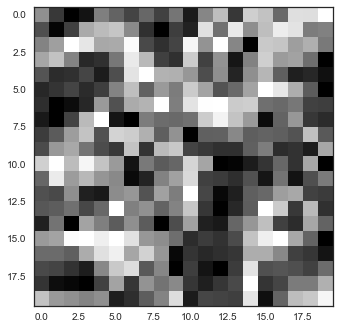

In [10]:
# make a figure for the first 25 filters
filterTiles = np.array([])
index = 0
for i in range(4):
    filterRow = []
    for j in range(4):
        w = weights[0][:,:,0,index]
        w = w.reshape(5,5)
        w = w-np.min(w)
        w = w / np.max(w)
        filterRow.extend(w)
        index+=1
    filterRow = np.array(filterRow)
    if not filterTiles.shape[0] == 0:
        filterTiles = np.hstack([filterTiles, filterRow])
    else:
        filterTiles = filterRow

plt.imshow(filterTiles, cmap='gray')    
plt.show()

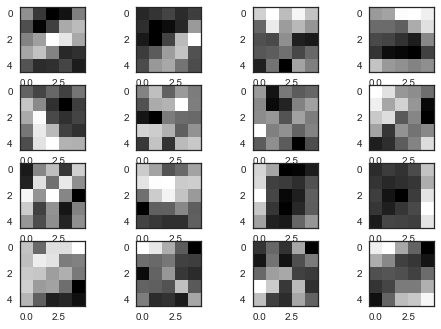

In [12]:
# make a figure for the first 25 filters
index = 0
for i in range(4):
    for j in range(4):
        w = weights[0][:,:,0,index]
        w = w.reshape(5,5)
        index+=1
        plt.subplot(4,4,index)
        plt.imshow(w, cmap='gray')    

plt.show()